# Import

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return ag

In [3]:
# Load data
df = pd.read_csv('PreprocessedData_v2.txt',
                               sep='\t',
                               decimal=',')
header = df.columns
df_arr =np.array(df, dtype='float64')
df =pd.DataFrame(df_arr, columns=header)

In [4]:
df.head(5)

,delta_t,acc0,acc1,acc2,gyro0,gyro1,gyro2,mag0,mag1,mag2,...,y,z,beta,Qx,Qy,Qz,Qw,delta_x,delta_y,delta_z
0,0.0000,-0.0029,0.0003,-0.0003,-0.0194,0.0124,-0.0022,-0.5292,-0.6538,-0.5275,...,0.221,0.402,-0.0129,0.005,0.020,0.000,1.0,0.0,0.0,0.0
1,0.0891,-0.0029,0.0013,0.0007,-0.0085,0.0023,0.0006,-0.5292,-0.6538,-0.4945,...,0.221,0.402,-0.0128,0.005,0.020,0.001,1.0,0.0,0.0,0.0
2,0.0810,-0.0039,0.0013,-0.0003,-0.0199,0.0086,-0.0024,-0.5162,-0.6538,-0.5275,...,0.221,0.402,-0.0133,0.005,0.021,0.000,1.0,0.0,0.0,0.0
3,0.3375,-0.0039,0.0013,0.0007,-0.0216,0.0054,-0.0002,-0.5162,-0.6538,-0.4945,...,0.221,0.402,-0.0129,0.005,0.020,0.000,1.0,0.0,0.0,0.0
4,0.0837,-0.0029,0.0023,0.0007,-0.0199,0.0171,0.0005,-0.5292,-0.6538,-0.4945,...,0.221,0.402,-0.0129,0.005,0.020,0.000,1.0,0.0,0.0,0.0


In [5]:
split = round(df.shape[0]*0.8)
print(split)

6142


In [6]:
# split into train and test sets
values = df.values
train = values[:split, :]
test = values[split:, :]
# split into input and outputs

#here comes the horizontal separation
train_X, train_y = train[:, :-11], train[:, -8]
test_X, test_y = test[:, :-11], test[:, -8]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6142, 1, 10) (6142,) (1536, 1, 10) (1536,)


Train on 6142 samples, validate on 1536 samples
Epoch 1/500
 - 4s - loss: 0.4502 - val_loss: 0.2625
Epoch 2/500
 - 0s - loss: 0.3045 - val_loss: 0.1670
Epoch 3/500
 - 0s - loss: 0.2141 - val_loss: 0.1765
Epoch 4/500
 - 0s - loss: 0.2134 - val_loss: 0.1727
Epoch 5/500
 - 0s - loss: 0.2108 - val_loss: 0.1688
Epoch 6/500
 - 0s - loss: 0.2089 - val_loss: 0.1658
Epoch 7/500
 - 0s - loss: 0.2066 - val_loss: 0.1625
Epoch 8/500
 - 0s - loss: 0.2044 - val_loss: 0.1599
Epoch 9/500
 - 0s - loss: 0.2022 - val_loss: 0.1572
Epoch 10/500
 - 0s - loss: 0.2003 - val_loss: 0.1547
Epoch 11/500
 - 0s - loss: 0.1981 - val_loss: 0.1520
Epoch 12/500
 - 1s - loss: 0.1961 - val_loss: 0.1494
Epoch 13/500
 - 0s - loss: 0.1938 - val_loss: 0.1468
Epoch 14/500
 - 0s - loss: 0.1918 - val_loss: 0.1437
Epoch 15/500
 - 0s - loss: 0.1895 - val_loss: 0.1406
Epoch 16/500
 - 0s - loss: 0.1876 - val_loss: 0.1376
Epoch 17/500
 - 0s - loss: 0.1854 - val_loss: 0.1336
Epoch 18/500
 - 0s - loss: 0.1830 - val_loss: 0.1301
Epoch 1

Epoch 154/500
 - 0s - loss: 0.1425 - val_loss: 0.0942
Epoch 155/500
 - 0s - loss: 0.1422 - val_loss: 0.0940
Epoch 156/500
 - 0s - loss: 0.1421 - val_loss: 0.0940
Epoch 157/500
 - 0s - loss: 0.1418 - val_loss: 0.0937
Epoch 158/500
 - 0s - loss: 0.1416 - val_loss: 0.0934
Epoch 159/500
 - 0s - loss: 0.1414 - val_loss: 0.0935
Epoch 160/500
 - 1s - loss: 0.1412 - val_loss: 0.0933
Epoch 161/500
 - 1s - loss: 0.1410 - val_loss: 0.0930
Epoch 162/500
 - 0s - loss: 0.1408 - val_loss: 0.0929
Epoch 163/500
 - 0s - loss: 0.1407 - val_loss: 0.0929
Epoch 164/500
 - 0s - loss: 0.1405 - val_loss: 0.0927
Epoch 165/500
 - 0s - loss: 0.1403 - val_loss: 0.0925
Epoch 166/500
 - 0s - loss: 0.1401 - val_loss: 0.0923
Epoch 167/500
 - 0s - loss: 0.1399 - val_loss: 0.0920
Epoch 168/500
 - 0s - loss: 0.1397 - val_loss: 0.0920
Epoch 169/500
 - 0s - loss: 0.1395 - val_loss: 0.0917
Epoch 170/500
 - 0s - loss: 0.1393 - val_loss: 0.0915
Epoch 171/500
 - 0s - loss: 0.1391 - val_loss: 0.0915
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 1s - loss: 0.1212 - val_loss: 0.0842
Epoch 307/500
 - 0s - loss: 0.1212 - val_loss: 0.0843
Epoch 308/500
 - 0s - loss: 0.1211 - val_loss: 0.0842
Epoch 309/500
 - 0s - loss: 0.1210 - val_loss: 0.0842
Epoch 310/500
 - 1s - loss: 0.1209 - val_loss: 0.0843
Epoch 311/500
 - 0s - loss: 0.1208 - val_loss: 0.0843
Epoch 312/500
 - 0s - loss: 0.1207 - val_loss: 0.0842
Epoch 313/500
 - 0s - loss: 0.1205 - val_loss: 0.0842
Epoch 314/500
 - 0s - loss: 0.1204 - val_loss: 0.0840
Epoch 315/500
 - 0s - loss: 0.1203 - val_loss: 0.0840
Epoch 316/500
 - 0s - loss: 0.1203 - val_loss: 0.0839
Epoch 317/500
 - 0s - loss: 0.1201 - val_loss: 0.0841
Epoch 318/500
 - 0s - loss: 0.1201 - val_loss: 0.0838
Epoch 319/500
 - 0s - loss: 0.1199 - val_loss: 0.0839
Epoch 320/500
 - 0s - loss: 0.1199 - val_loss: 0.0841
Epoch 321/500
 - 0s - loss: 0.1197 - val_loss: 0.0839
Epoch 322/500
 - 0s - loss: 0.1197 - val_loss: 0.0840
Epoch 323/500
 - 0s - loss: 0.1196 - val_loss: 0.0841
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 1s - loss: 0.1117 - val_loss: 0.0819
Epoch 459/500
 - 1s - loss: 0.1114 - val_loss: 0.0826
Epoch 460/500
 - 0s - loss: 0.1117 - val_loss: 0.0819
Epoch 461/500
 - 1s - loss: 0.1113 - val_loss: 0.0825
Epoch 462/500
 - 0s - loss: 0.1116 - val_loss: 0.0822
Epoch 463/500
 - 0s - loss: 0.1113 - val_loss: 0.0825
Epoch 464/500
 - 1s - loss: 0.1116 - val_loss: 0.0822
Epoch 465/500
 - 1s - loss: 0.1112 - val_loss: 0.0826
Epoch 466/500
 - 1s - loss: 0.1115 - val_loss: 0.0822
Epoch 467/500
 - 0s - loss: 0.1112 - val_loss: 0.0829
Epoch 468/500
 - 0s - loss: 0.1114 - val_loss: 0.0823
Epoch 469/500
 - 1s - loss: 0.1111 - val_loss: 0.0827
Epoch 470/500
 - 0s - loss: 0.1113 - val_loss: 0.0825
Epoch 471/500
 - 1s - loss: 0.1109 - val_loss: 0.0829
Epoch 472/500
 - 0s - loss: 0.1113 - val_loss: 0.0824
Epoch 473/500
 - 0s - loss: 0.1109 - val_loss: 0.0827
Epoch 474/500
 - 0s - loss: 0.1111 - val_loss: 0.0825
Epoch 475/500
 - 0s - loss: 0.1108 - val_loss: 0.0826
Epoch 476/500
 - 1s - loss: 

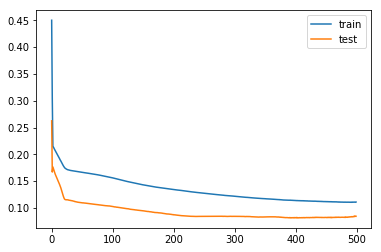

In [7]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [8]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [9]:
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.185
